<h2> Predict Loan Defaulters Part 1 - Exploratory Data Analysis</h2>

<h4> This notebook walks through handling a dataset with 145 dimensions together with all the nuances that comes with a real-world dataset.</h4>
    
<h4> This project expands on a Data Mining Capstone Project I submitted for my Msc in Big Data Analytics @ The University of Liverpool </h4>

### Problem Understanding and Definition

Lending club is an organization that brings borrowers and investors together transforming the way people access credit. <br>
They have been collecting data on loan applications which could be used to predict loan defaulters based on a borrowers profile whether they will be able to repay their loans. <br>
    
The dataset used is real world data for all approved and declined loan applications from the Lending Club, which they make public (anonymized). <br>

[Link to Lending Club](https://www.lendingclub.com/)

This type of challenge is referred to a binary classification problem. The domain is finance and the dateset contains over 145 features.<br>
In a real world scenario, understanding each field in detail with business domain experts would be crucial to ensure each field is interpreted/considered within its own merits. <br>
We will be using a Data Dictionary provided by Lending Club and general knowledge of banking to make some of these decisions absent of the experts. <br>

This notebook goes through the Exploratory Data Analysis Phase. There second notebook found through the link below that goes through the pre-processing steps <br> 

[Link to Data Cleaning Notebook](https://koremarcel.com/project-predicting-loan-defaulters-_part-2-data-cleaning/)
    
Associated functions used in this notebook can be viewed at my github link below. <br>
    
[Github Link to orginial notebooks and helper files](https://github.com/marcelkore/LendingClub_LoanDefaulters)

### Notebook Setup
1. [Load Data](#load_data)
3. [Exploratory Data Analysis](#exploratory)
2. [Missing Values](#missing_values)
3. [Univariate EDA](#univariate)
3. [Bivariate EDA](bivariate)
4. [Categorical EDA](#categoricalEDA)
4. [Time-Series](#timeseries)

In [6]:
# Standard Libraries
import pandas as pd
import numpy as np

#sklearn libraries
from sklearn.preprocessing import LabelEncoder

# time series analysis
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# missing values
import missingno as msno

# Viz Libraries
import seaborn as sns
sns.set(style='darkgrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
import matplotlib.style as style
import matplotlib.pyplot as plt
style.use('fivethirtyeight')
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload

pd.set_option("display.precision", 2)

#helper functions
import helper_functions as helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Helper Functions

In [8]:
# function to drop features easily
def drop_features(feature_name):
    df.drop(labels=feature_name,axis=1,inplace=True)

## Reading the Dataset 
<a id="load_data"></a>

We will be using data from 2016 to 2017 for training and data from 2014 and 2018 for testing

In [9]:
df = pd.read_csv("accepted_2007_to_2018Q4.csv",parse_dates=['issue_d'])
df.shape

(2260701, 151)

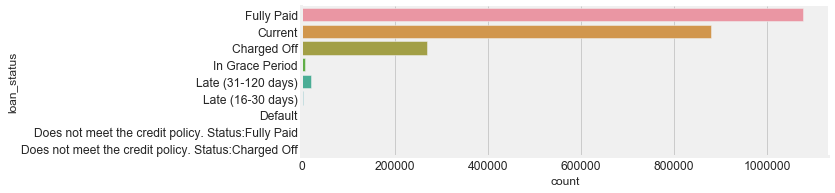

In [5]:
# review our target feature distribution
sns.catplot(y="loan_status", kind="count", data=df, height=2.6, aspect=4.5, orient='h')
plt.show();

This first transformer takes the loan dataset as input and maps only Fully Paid and Non-Current examples in the dataset as defaulters <br>
and non-defaulters. We will make the assumption that 'Current' examples are still in flight and thus we cannot be sure if they will be fully <br>
or default at some point.

In [6]:
class SelectTargetFeature(TransformerMixin,BaseEstimator):
    """
    This transformer takes as input a dataframe and encodes selected features. 
    As a secondary step, it also filters the dataset to only fully paid and 
    charged off loans
    
    Args: Pass a dataframe
    
    Returns: 
    A dataframe containing target feature label encoded.
    The dataframe will also be filtered for charged off and fully paid observations only.
    
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df): # pass the dataframe
        
        # cleaning "loan_status"
        df['loan_status'] = df['loan_status'].map({'Current': 2, 'Fully Paid': 1, \
                                                         'Charged Off':0, 'Late(31-120 days)':0,\
                                                         'In Grace Period': 0,\
                                                         'Late(16-30 days)': 0, 'Default': 0})
        
        # filter out 'current laons'
        df = df[df.loan_status != 2] 
        
        # map charged off, late and grace observations to 0
        # fully paid will be mapped to 1        
        df["loan_status"] = df["loan_status"].apply(lambda loan_status: 0 if loan_status == 0 else 1)
        
        # convert loan status to category datatype    
        df['loan_status'] = df['loan_status'].astype('category')
        return df      

In [7]:
# create transformer object
select_feature = SelectTargetFeature()

# fit transform the dataset
df = select_feature.fit_transform(df)

In [8]:
print("Data Set Size: {}".format(df.shape))

Data Set Size: (1382384, 151)


<h2> Exploratory Data Anaylysis </h2>
<a id="exploratory"></a>

<h4> We will have the following goals </h4>
<ol>
  <li>Applying standard techniques to get a better understanding of our dataset </li>
  <li>Form a hypothesis about some aspects of the dataset from the context of the problem</li>
  <li>Apply EDA techniques to begin confirming or rejecting our hypothesis and preconcieved ideas </li>
</ol> 


<h4> Based on the outcome, we should be able to answer the following questions when done </h4>

* What types of variables are there in the dataset? <br>
* What do their distributions look like? <br>
* Do we have missing values? <br> 
* Are there redundant features? <br>
* What are the relationships between the main features? <br>
* Do we observe outliers? <br>
* How do the different pairs of features correlate with one other? Do these correlations make sense? <br>
* What is the relationship between the features and the target? <br>
* Have you confirmed or rejected your hypothesis? <br>
* What do you know now that will inform the modeling strategy? <br>


<img src="https://marcelblobdatabricks.blob.core.windows.net/cleaningimage/eda%20features.png" width="1000" height="600"> <br>

[Image Source](https://towardsdatascience.com/analyze-the-data-through-data-visualization-using-seaborn-255e1cd3948e)

From the diagram above, EDA can be performed using a number of methods depending on the type of dataset. <br>
We will perform EDA based on a subset of the most interesting features using both descriptive statistics and visualizations <br>

In [9]:
# get info on our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382384 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: category(1), datetime64[ns](1), float64(113), object(36)
memory usage: 1.6+ GB


In [10]:
# store numeric features for separte review
df_numeric = df.select_dtypes(exclude='object')

In [11]:
# store categoricl features for separate
df_categorical = df.select_dtypes(include="object")

#### Drop Features
We will drop features from the dataset that will not inform our modeling decisions

In [12]:
drop_features(['id','member_id','url','emp_title','title','desc'])

### Loan Status
<h5> We will only consider fully paid and charged off examples for our EDA for expediency </h5>

In [13]:
# Get definitions from the DD
helpers.data_dictionary(data=["loan_status"])

,feature,Description
42,loan_status,Current status of the loan


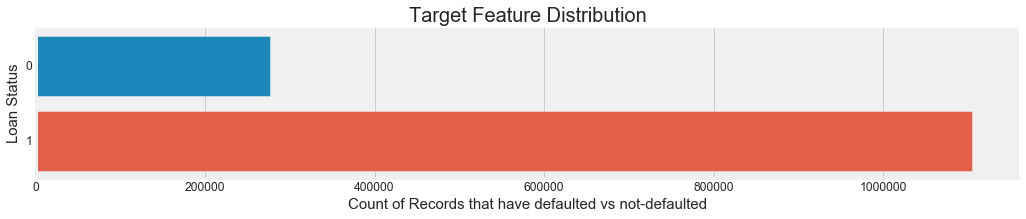

In [14]:
# Lets visualize our target feature using a seaborn plot
sns.catplot(y="loan_status", kind="count", data=df, height=2.6, aspect=5.5, orient='h',);
plt.title("Target Feature Distribution", size=20);
plt.xlabel("Count of Records that have defaulted vs not-defaulted",size=15)
plt.ylabel("Loan Status",size=15)
plt.show();

In [15]:
df['loan_status'].value_counts(normalize=True, dropna=False) * 100

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1    79.96
0    20.04
Name: loan_status, dtype: float64

<p> Looking at our Target Feature, we notice an imbalance present regarding the # of observations for fully paid loans vs charged off. <br>
    This is our first important observation
    
* We will have to address this to prevent overfitting caused by a biased dataset.
* We also need to remember to use stratify where applicable to ensure equal samples are present in our split

### Column Data Types

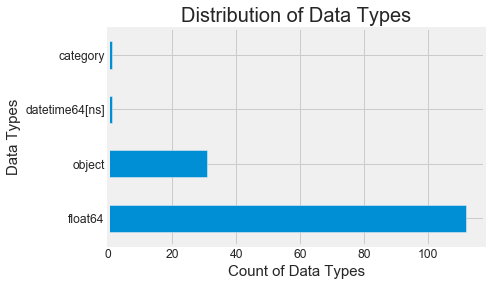

In [16]:
df.dtypes.value_counts().plot(kind='barh')
plt.xlabel("Count of Data Types",size=15)
plt.ylabel("Data Types",size=15)
plt.title("Distribution of Data Types", size=20)
plt.show();

Object datatypes tend to take up alot of memory while processing. We can converted them to the newer 'category data type' for easier, quicker processing <br>
One caveat is that some algorithms do not play nice with the category  data type. I have faced issues with Catboost and category data types. 

#### **Convert DataTypes**
As stated above, due to the large dataset and the 'object' datatype memory footprint, the transformer below converts object datatype to category

In [17]:
class ConvertDataTypes(TransformerMixin,BaseEstimator):
    """
    This transformer receives a dataframe performs the following conversion:
    
    Any 'object' datatypes present converted to 'category'
    Any 'float64' datatypes present covnerted to 'float32'
    
    Args: Pasa a dataframe
    
    Returns: 
    A dataframe with the data types converted
    
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df): # pass the dataframe
        # memory management - object to category
        for value in df:
            if df[value].dtype == 'object':
                df[value] = df[value].astype('category')
        
        return df      

In [18]:
# create transformer 
encoder = ConvertDataTypes()
#fit transform dataset
df = encoder.fit_transform(df)
print("Dataframe shape: {} ".format(df.shape))

Dataframe shape: (1382384, 145) 


### Number of Unique Values in Each of the Categoricals
Below we can observer a snapshot of the categorical features in our dataset. We can start identifying features that can be dropped <br>
due to a high number of unique observations. Zip code can be used to geographical  plotting. Some of the dates can also be used in time-series analysis <br>
These can be converted as needed to datetime formats

In [19]:
df.select_dtypes('category').apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

zip_code                     946
earliest_cr_line             739
sec_app_earliest_cr_line     585
last_credit_pull_d           141
last_pymnt_d                 136
next_pymnt_d                 102
settlement_date               90
debt_settlement_flag_date     83
addr_state                    51
sub_grade                     35
hardship_end_date             28
payment_plan_start_date       27
hardship_start_date           27
purpose                       14
emp_length                    11
hardship_reason                9
grade                          7
home_ownership                 6
hardship_loan_status           5
verification_status_joint      3
settlement_status              3
verification_status            3
hardship_status                3
loan_status                    2
initial_list_status            2
pymnt_plan                     2
debt_settlement_flag           2
disbursement_method            2
application_type               2
hardship_flag                  2
term      

<h2> Missing Values </h2>
<a id="missing_values"></a>

In [20]:
# get a distribution of the missing values in the dataset
helpers.missing_values_table(df).head(5)
helpers.missing_values_table(df).sample(5)
helpers.missing_values_table(df).tail(5)

Your selected dataframe has 145 columns.
There are 144 columns that have missing values.


,Missing Values,% of Total Values
orig_projected_additional_accrued_interest,1376565,99.6
hardship_end_date,1374380,99.4
hardship_start_date,1374380,99.4
hardship_type,1374380,99.4
hardship_reason,1374380,99.4


Your selected dataframe has 145 columns.
There are 144 columns that have missing values.


,Missing Values,% of Total Values
max_bal_bc,813188,58.8
last_credit_pull_d,90,0.0
num_rev_tl_bal_gt_0,70309,5.1
inq_last_6mths,63,0.0
total_pymnt,33,0.0


Your selected dataframe has 145 columns.
There are 144 columns that have missing values.


,Missing Values,% of Total Values
initial_list_status,33,0.0
application_type,33,0.0
revol_bal,33,0.0
collection_recovery_fee,33,0.0
loan_amnt,33,0.0


From the tables above, we have what seems to be a lot of features with varying degrees of missing values that will need to be accounted for.How one <br>
handles missing values can be performed blindly i.e., imputing all instances my their mean/median or most frequent values for categorical data <br>

Another time-consuming route is to perform missingness analysis and determine why some features are missing. I write more about that in this blog post INSERT BLOG POST LINK

One way to determine one of the missingness categories namely MCAR is to plot the distribution of the feature with and without missing features. <br>
We will select a few features to review.

In [21]:
# select subset of features to analyze for missingness
df_temp = df[['loan_amnt','total_rec_prncp',
              'annual_inc','annual_inc_joint',
              'dti','dti_joint',]]

In [22]:
helpers.missing_values_table(df_temp)

Your selected dataframe has 6 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
dti_joint,1352803,97.9
annual_inc_joint,1352800,97.9
dti,445,0.0
annual_inc,37,0.0
loan_amnt,33,0.0
total_rec_prncp,33,0.0


In [23]:
# review definitions of the field
helpers.data_dictionary(df_temp.columns)

,feature,Description
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
17,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"
41,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
109,total_rec_prncp,Principal received to date


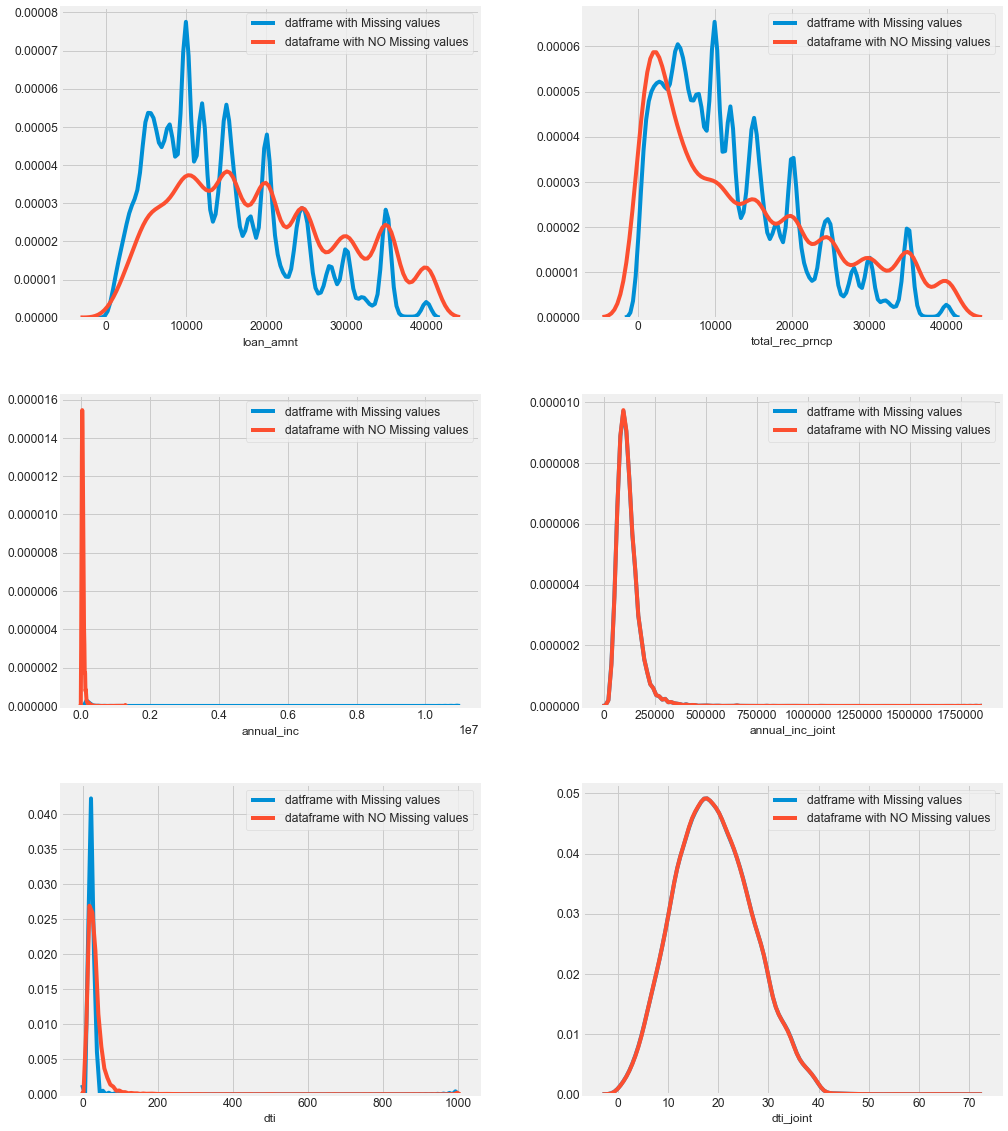

In [24]:
# the code below plots distributions with and without missing values 
helpers.dist_comparison(df_temp, df_temp.dropna())

From the plots above, we can surmise that loan_amnt and tot_rec_prncp are MCAR due to the difference between the two distributions. <br>
This can inform our strategy during the pre-processing stage regarding how we impute the features

<h2> Univariate EDA </h2>
<a id="univariate"></a>

Univarite EDA is EDA applied to a single feature in order to understand each feature individually. We have a lot of features in this <br>
dataset and so we will only explore a few interesting ones </p>

We already split our dataset into different categories for easy EDA. Lets start by analyzing their statistics

In [27]:
pd.options.display.float_format = '{:20,.2f}'.format

#### Annual_Inc

In [28]:
helpers.data_dictionary(['annual_inc'])

,feature,Description
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [29]:
helpers.data_dictionary(['annual_inc_joint'])

,feature,Description
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration


In [30]:
df['annual_inc'].describe()

count           1,382,347.00
mean               76,290.12
std                70,270.46
min                     0.00
25%                45,760.00
50%                65,000.00
75%                90,000.00
max            10,999,200.00
Name: annual_inc, dtype: float64

In [31]:
# check joint annual inc
df['annual_inc_joint'].describe()

count              29,584.00
mean              117,605.44
std                59,943.22
min                 9,000.00
25%                80,000.00
50%               106,600.00
75%               140,000.00
max             1,837,000.00
Name: annual_inc_joint, dtype: float64

In [32]:
# calculate the annual income median value
df['annual_inc'].median()

65000.0

Looking at the median value confirms that we do have some outliers in the data as the median income is 66,000. We also have a few outliers in the dataset <br>
as we can see a maximums of $ 10 million for the annual income. This could be an indicator of lack of input validation at the source.

In [33]:
# max and median loan amounts
df['loan_amnt'].max()
df['loan_amnt'].median()

40000.0

12000.0

In the context of the problem statement, it does not seem plausible that millionares are borrowing such small amounts as evidenced by the maximum loan amounts <br>
available in the dataset. It seems like lending club is not validating or capping annual income value provided by individuals.

With a median and mean loan amount of 40,000 and 12,000 respectively, it seems odd that people are reporting such high annual incomes.I must be missing something here 🤔

In [34]:
# Looking at the median value confirms that we do have some outliers
# The median value is immune to outliers and provides a better metric
df['annual_inc_joint'].median()

106600.0

Lets see how many people in the dataset made above 150,000 (self reported)

In [35]:
print('Self Reported income over 150,000: {} '.format(df[df['annual_inc'] > 150000].shape[:1]))
print('Self Reported income over 250,000: {} '.format(df[df['annual_inc'] > 250000].shape[:1]))
print('Self Reported income over 350,000: {} '.format(df[df['annual_inc'] > 350000].shape[:1]))
print('Self Reported income over 500,000: {} '.format(df[df['annual_inc'] > 500000].shape[:1]))

Self Reported income over 150,000: (73381,) 
Self Reported income over 250,000: (13916,) 
Self Reported income over 350,000: (5214,) 
Self Reported income over 500,000: (1814,) 


#### Revolving Balance

In [36]:
helpers.data_dictionary(['revol_bal'])

,feature,Description
90,revol_bal,Total credit revolving balance


In [37]:
df['revol_bal'].describe()

count           1,382,351.00
mean               16,251.39
std                22,437.32
min                     0.00
25%                 5,925.00
50%                11,119.00
75%                19,740.00
max             2,904,836.00
Name: revol_bal, dtype: float64

The revol_bal seems unusually high especially for people borrowing only 40,000. Maybe this could be a useful feature during feature engineering 

In [38]:
# lets get the median value here too
df['revol_bal'].median()

11119.0

### Total Collection Amount

In [39]:
helpers.data_dictionary(['tot_coll_amt'])

,feature,Description
96,tot_coll_amt,Total collection amounts ever owed


In [40]:
df['tot_cur_bal'].describe()

count           1,312,075.00
mean              140,965.28
std               157,496.23
min                     0.00
25%                29,362.00
50%                79,769.00
75%               210,500.00
max             8,000,078.00
Name: tot_cur_bal, dtype: float64

In [41]:
df['tot_cur_bal'].median()

79769.0

I could not understand the context of total collection amount from the data dictionary. Is this loan repayment or loans that have defaulted? <br>
If this is the latter, then most loan applicants have had a scary past based on the numbers with a median loan collection amount of $79769

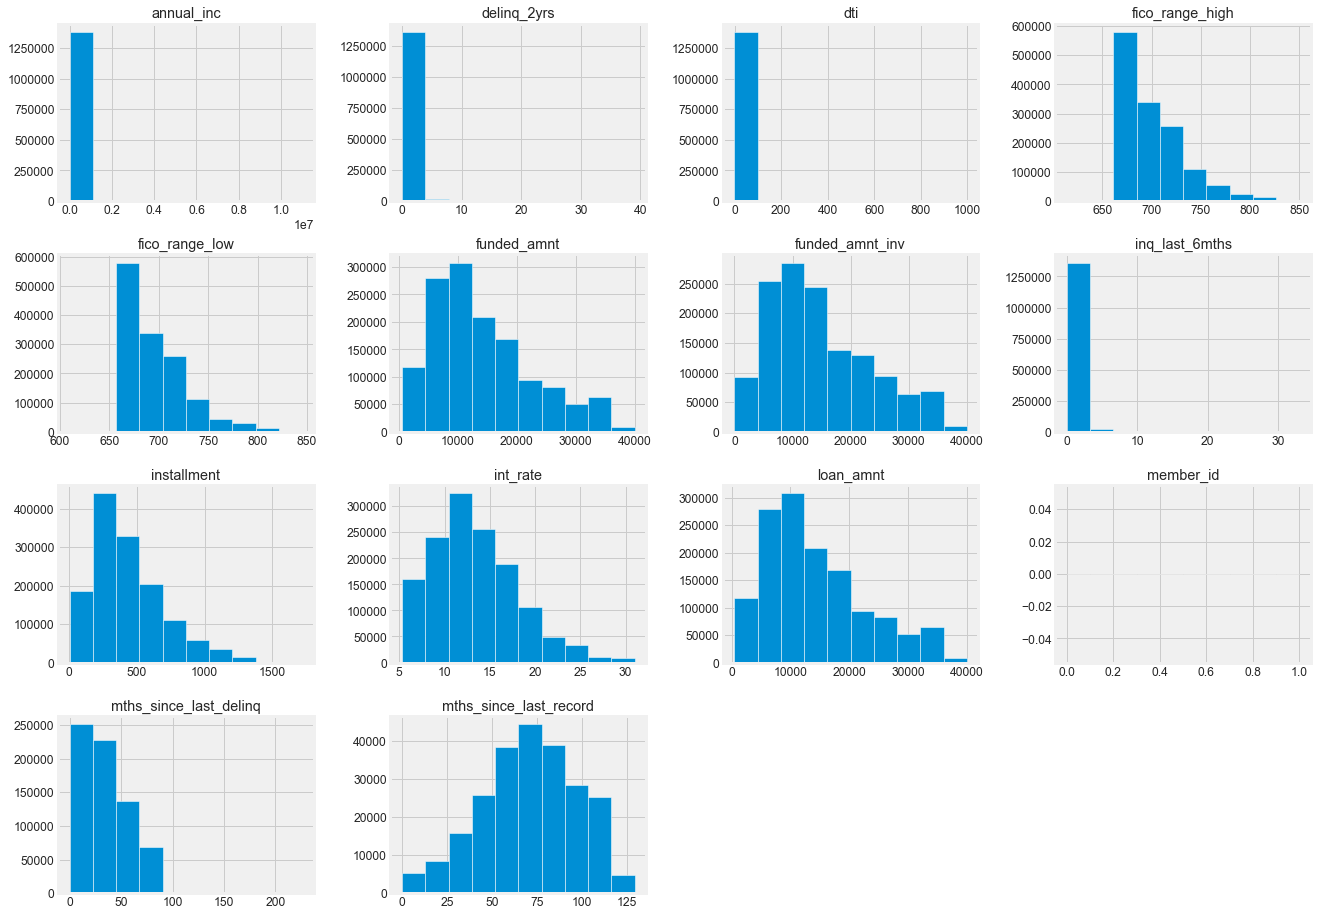

In [42]:
# make general plots to examine each feature distribution
df_numeric.iloc[:,0:16].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

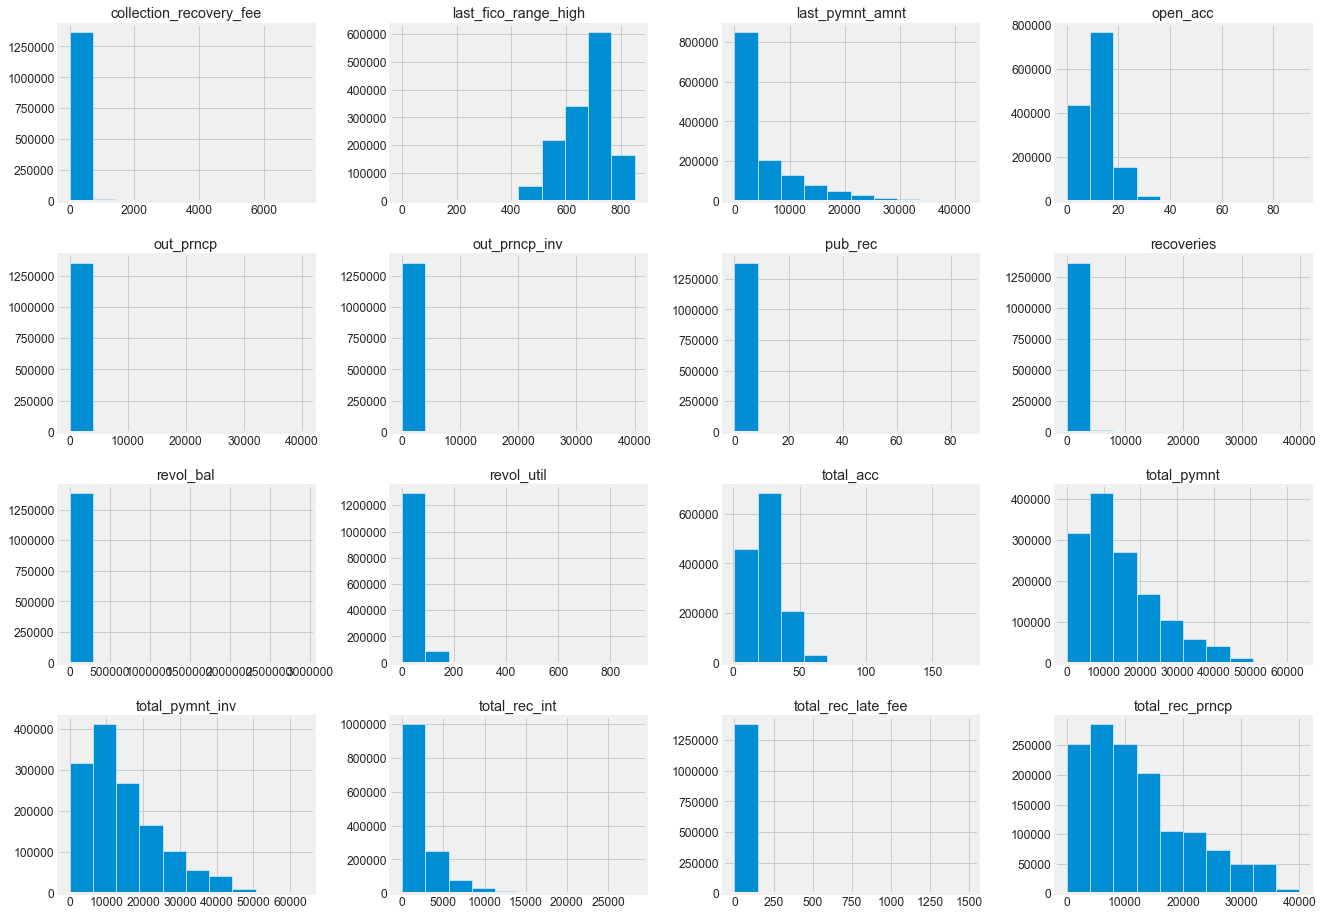

In [43]:
# make general plots to examine each feature
df_numeric.iloc[:,16:32].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

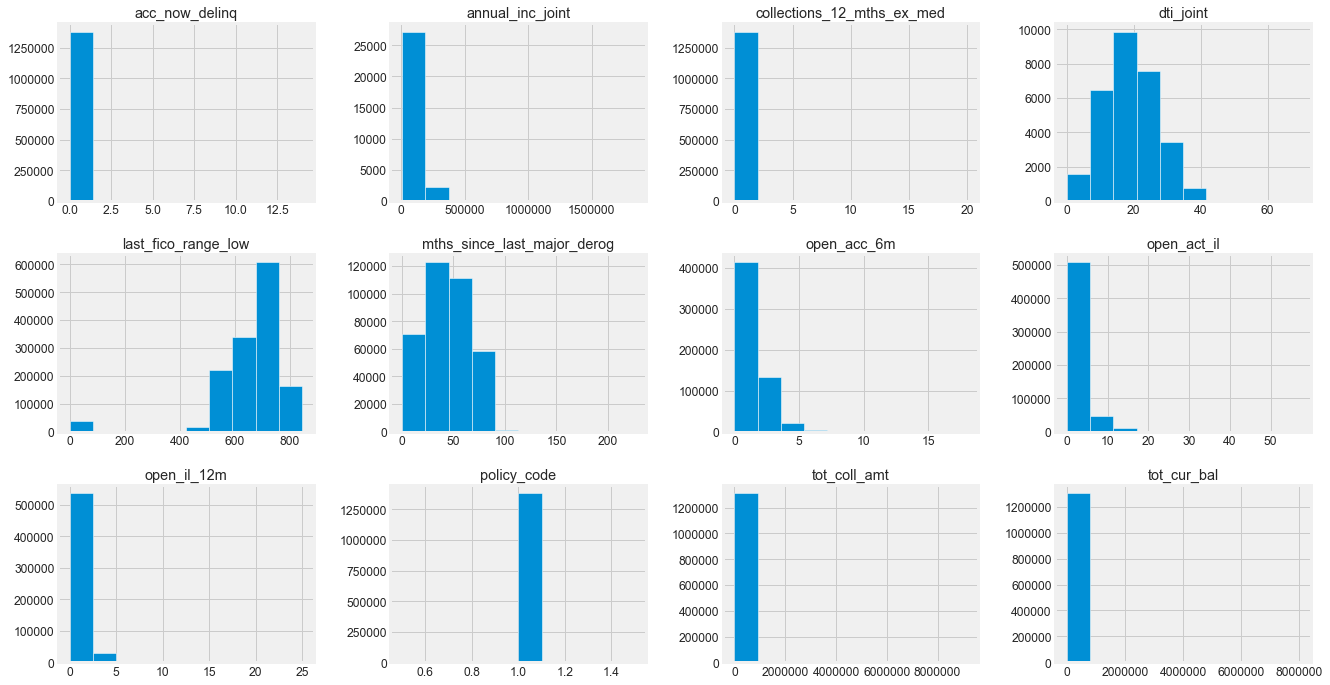

In [44]:
# make general plots to examine each feature
df_numeric.iloc[:,32:44].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

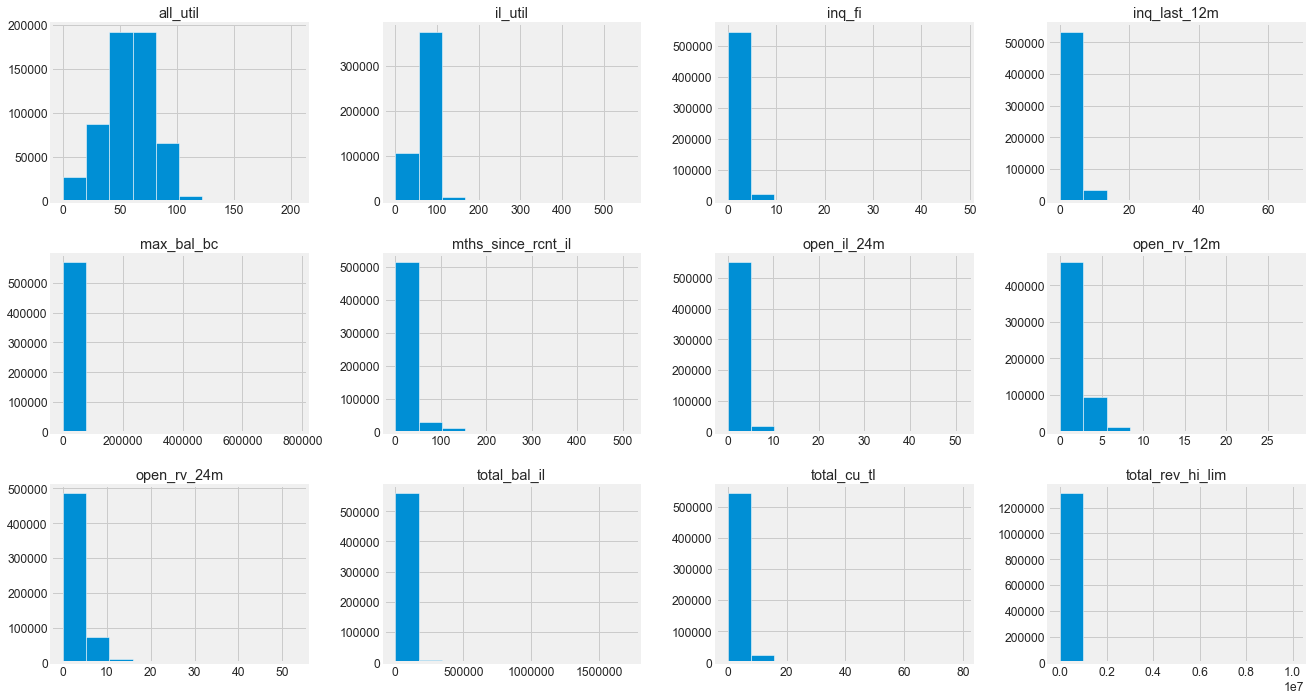

In [45]:
# make general plots to examine each feature
df_numeric.iloc[:,44:56].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

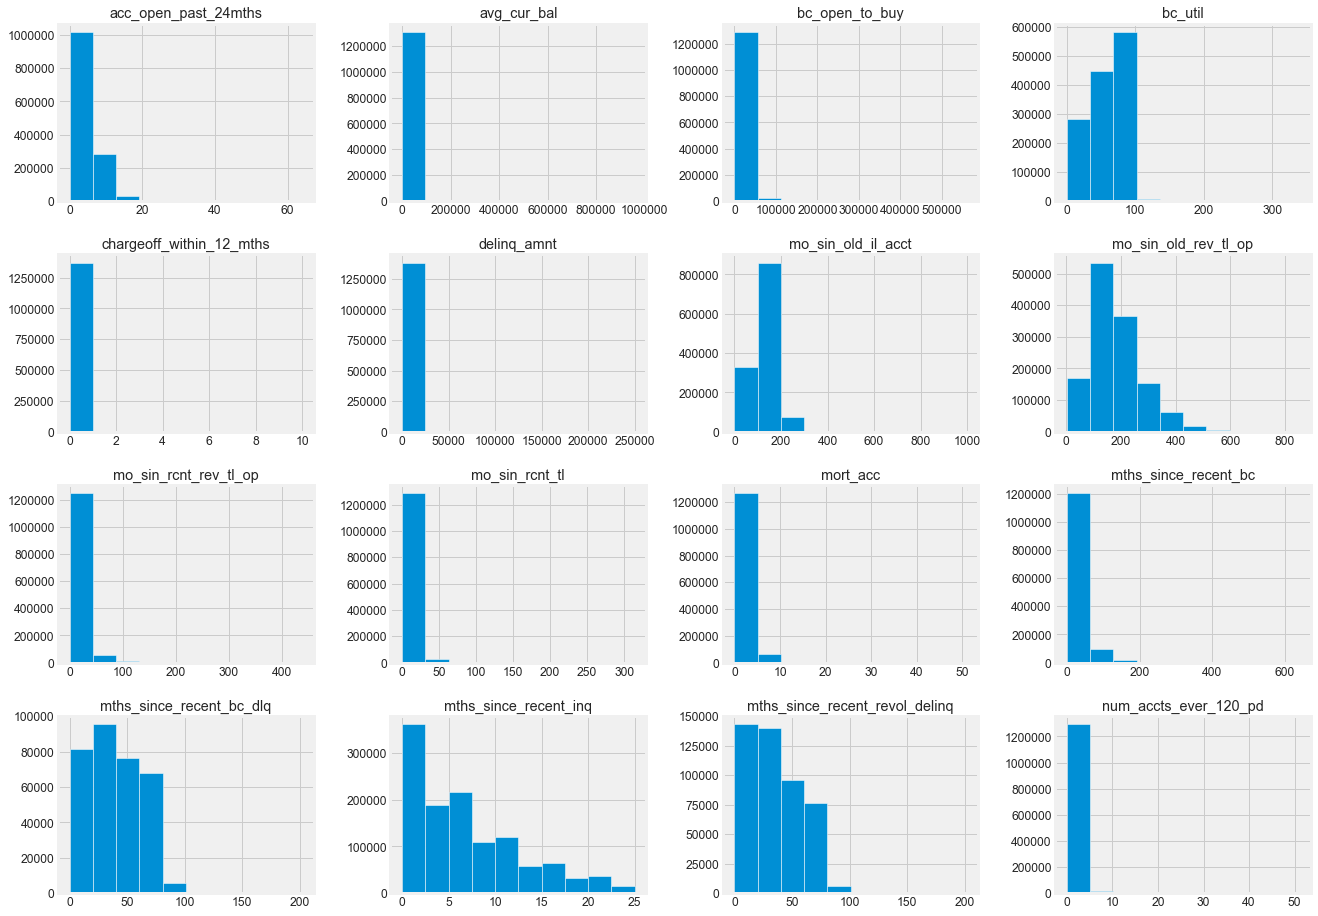

In [46]:
# make general plots to examine each feature
df_numeric.iloc[:,56:72].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

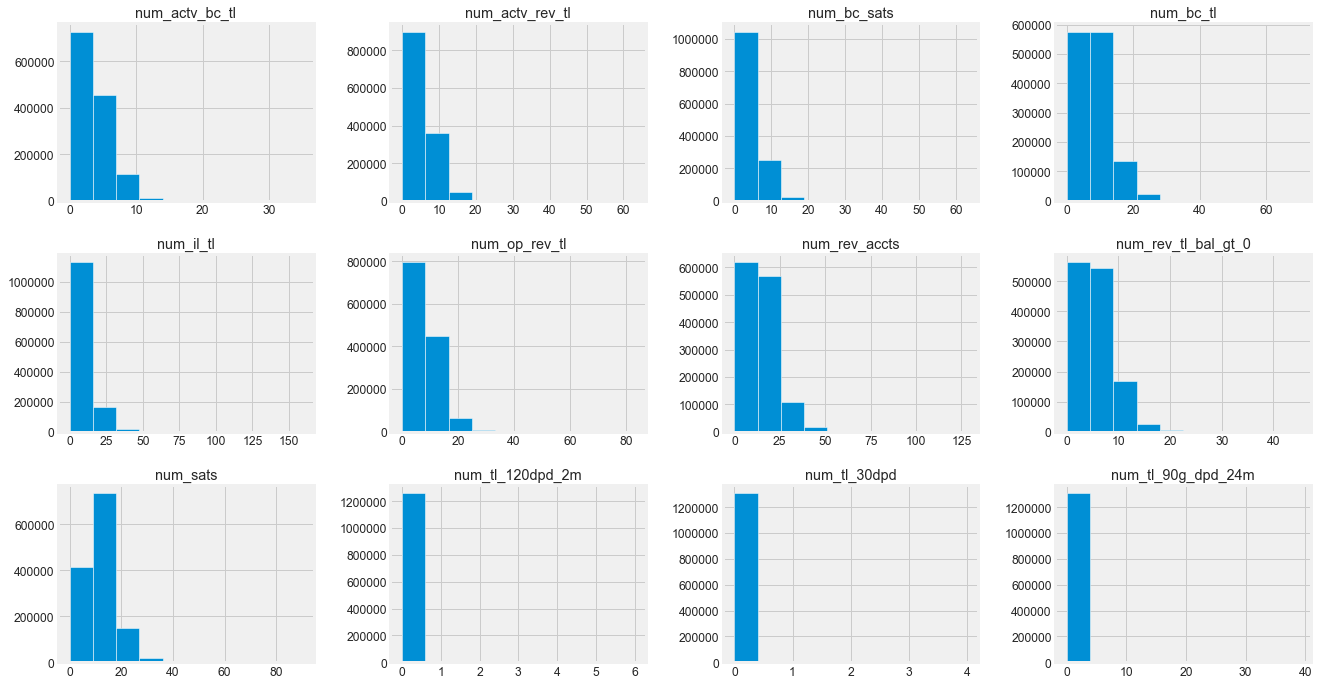

In [47]:
# make general plots to examine each feature
df_numeric.iloc[:,72:84].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

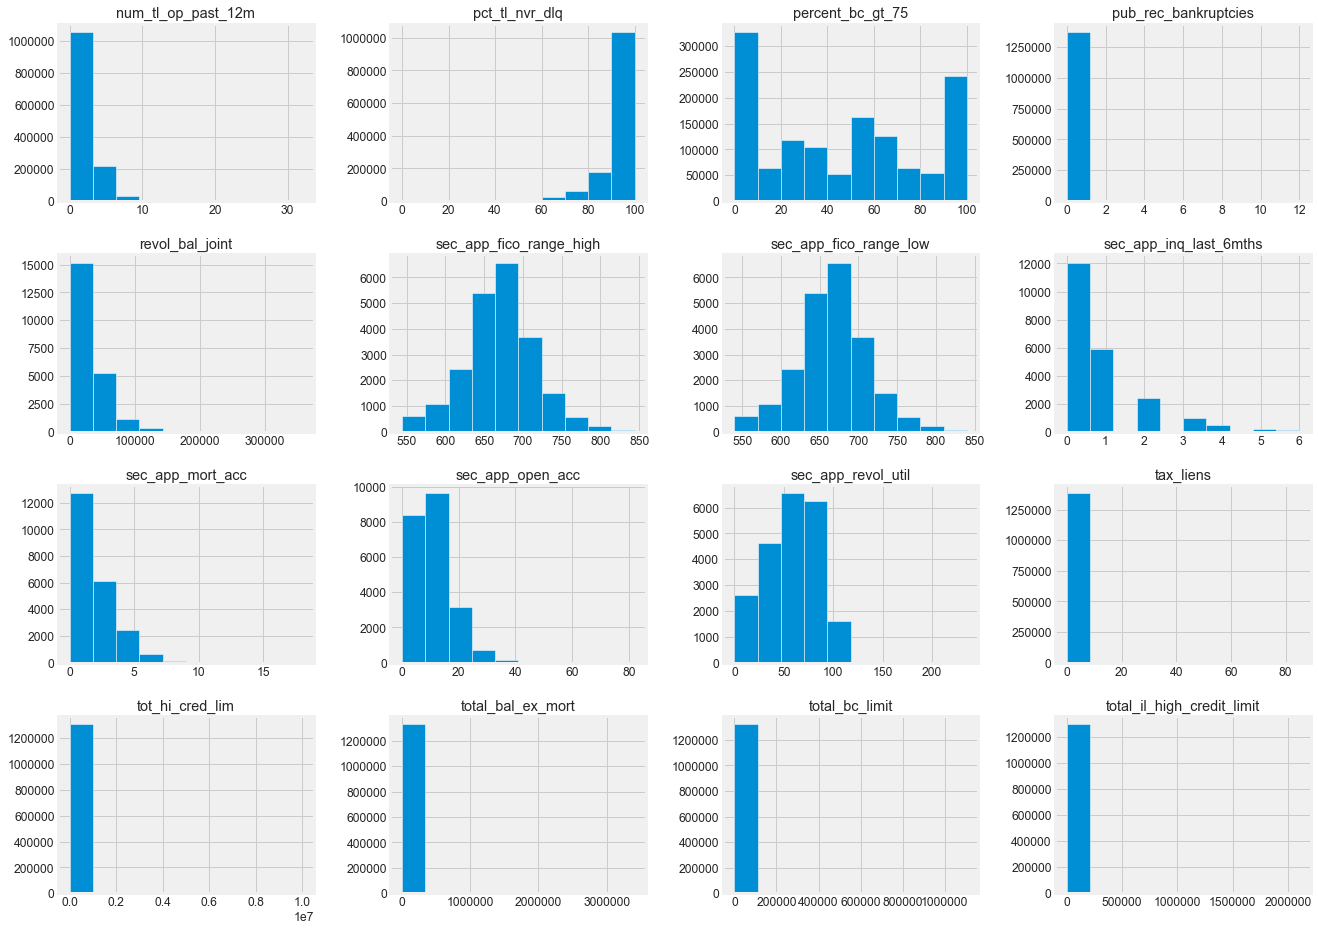

In [48]:
# make general plots to examine each feature
df_numeric.iloc[:,84:100].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(4,4));

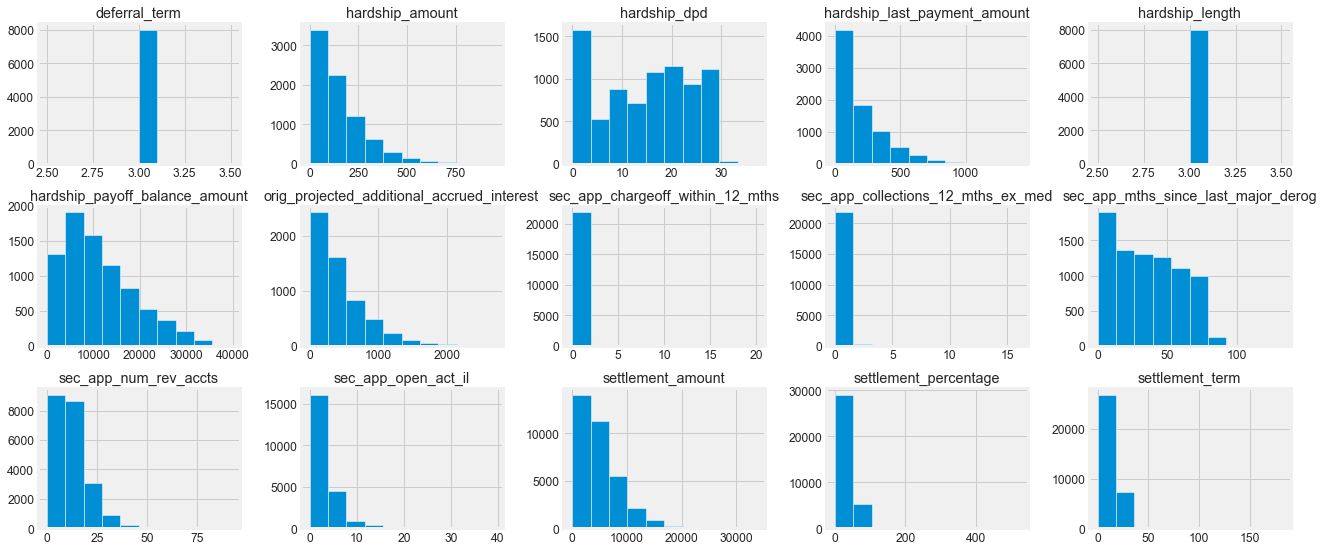

In [49]:
# make general plots to examine each feature
df_numeric.iloc[:,100:].hist(edgecolor="white",bins=10,figsize=(20,16),layout=(5,5));

Looking at the plots above reveals that we have a fairly cringeworthy dataset with 'real-world' distributions. <br>
We can infer the following observations 

* we can see  multiple skewed features
* skewness might indicate the presence of outliers
* some of the features have single  unique values i.e., zeros that have to be accounted for
* different scales in the dataset have to be accounted for depending on the final algorithm we choose

The above plots are also important to note as most algorithms operate with specific assumptions i.e., assuming the data has a gaussian or normal distrubution. <br>
Having this information handy will ensure we make the correct decisions during the pre-processing phase


## Bivariate EDA
<a id="bivariate"></a>

Across different metrics, what is the behaviour between charged off loans and non-defaulting loans

In [50]:
# select a few features to analyze
numeric_features_of_interest_1 = ['loan_amnt','annual_inc','funded_amnt','int_rate','dti','fico_range_low']
numeric_features_of_interest_2 = ['fico_range_high','revol_bal','pub_rec','mths_since_last_major_derog']

In [51]:
df.groupby(['loan_status'])[numeric_features_of_interest_1].agg([np.median, np.std])

loan_amnt                                annual_inc  \
                          median                  std               median   
loan_status                                                                  
0                      14,400.00             8,852.13            60,000.00   
1                      12,000.00             8,704.62            65,000.00   

                                          funded_amnt                       \
                             std               median                  std   
loan_status                                                                  
0                      65,600.34            14,400.00             8,848.74   
1                      71,325.29            12,000.00             8,700.78   

                        int_rate                                       dti  \
                          median                  std               median   
loan_status                                                                  
0                          15.05                 4.92                19.74   
1                          12.29                 4.57                17.13   

                                       fico_range_low                       
                             std               median                  std  
loan_status                                                                 
0                          11.96               680.00                26.04  
1                          11.15               690.00                32.76

Observations:
* defaulters (0) are showing lower median annual_income and understandbly higher funded amounts and interest rates 
* non-defaulters (1) are showing higher annual incomes and lower interest rates. This falls inline with assumptions on non-defaulters 
* fico_scores seem to be only slightly different between the two groups

In [52]:
df.groupby(['loan_status'])[numeric_features_of_interest_2].agg([np.median, np.std])

fico_range_high                                 revol_bal  \
                          median                  std               median   
loan_status                                                                  
0                         684.00                26.04            11,080.00   
1                         694.00                32.77            11,128.00   

                                              pub_rec                       \
                             std               median                  std   
loan_status                                                                  
0                      19,107.15                 0.00                 0.65   
1                      23,192.25                 0.00                 0.59   

            mths_since_last_major_derog                       
                                 median                  std  
loan_status                                                   
0                                 43.00                21.58  
1                                 44.00                21.33

In [53]:
def plot_bar_plot(feature_name,target_feature):
    '''
    Function to quickly plot barplots.
    
    :param feature_name: first feature to compare
    :param target_feature: second feature to compare
    :return: plots
    
    '''
    dd_feature_name = []
    dd_feature_name.append(feature_name)
    df.groupby([target_feature])[feature_name].median().\
    plot(kind='barh',figsize=(8,4),color=tuple(["r", "g"],));
    plt.xlabel(feature_name + " distribution", size =15);
    plt.ylabel(target_feature, size = 15); 
    plt.title(feature_name + ' by '+ target_feature, size=15);
    return  helpers.data_dictionary([feature_name])

The not-so surprising observation here is that non-defaulters have greater number of months since their last derogatory records

,feature,Description
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."


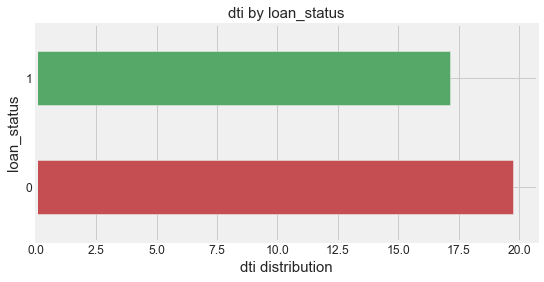

In [54]:
plot_bar_plot('dti', 'loan_status')

As expected, non-defaulters (1) have a lower debt to income ratio (DTI). DTI is  a ratio of all monthly debt payments divided by the gross monthly income of the individual. <br>According to the consumer financial protection bureau, borrowers with a higher DTI are more likely to run into trouble making monthly payments (CFPB, 2019)

,feature,Description
23,funded_amnt,The total amount committed to that loan at that point in time.


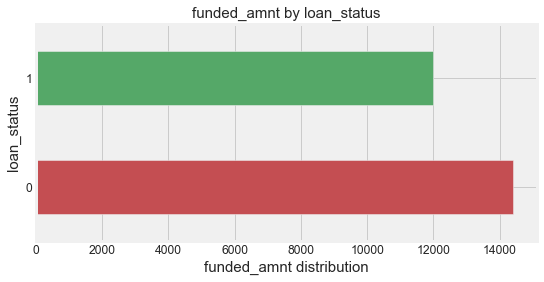

In [55]:
plot_bar_plot('funded_amnt', 'loan_status')

Defaulters have higher funded amounts according the plot above. They are being approved for large loans

,feature,Description
34,int_rate,Interest Rate on the loan


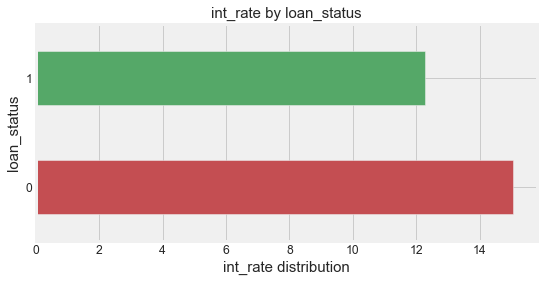

In [56]:
plot_bar_plot('int_rate', 'loan_status')

Not-so surprising, defaulters have higher interest rates. This means that they are paying more over the life of the loan. <br>

In [57]:
def plot_aggregate_bar_plot(feature_name, target_feature):
    '''
    Function to quickly aggregate barplots
    '''
    pd.crosstab(df[target_feature], df[feature_name]).plot(kind='barh',figsize=(8,4));
    plt.title(feature_name + " distribution by " + target_feature,size=15);
    plt.xlabel('count of ' + feature_name + ' types', size=15); plt.ylabel(target_feature,size=15)
    plt.show();
    return  helpers.data_dictionary([feature_name])

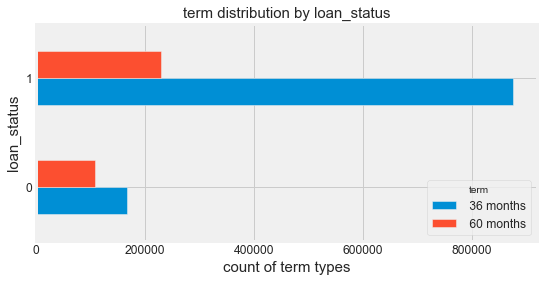

,feature,Description
94,term,The number of payments on the loan. Values are in months and can be either 36 or 60.


In [58]:
plot_aggregate_bar_plot('term','loan_status')

In [59]:
df.term.value_counts()

 36 months    1043059
 60 months     339292
Name: term, dtype: int64

36 month loans seem to be the most frequent types of loans offered

In [60]:
helpers.data_dictionary(['purpose'])
pd.crosstab(df['loan_status'], df['purpose'])

,feature,Description
87,purpose,A category provided by the borrower for the loan request.


purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
loan_status,,,,,,,,,,,,,,
0,2219,51660,170033,56,16063,1649,5663,3495,2273,16957,222,4691,1775,279
1,12730,250471,631404,367,73982,5939,24750,12568,7533,63828,733,11407,7533,2071


In [61]:
df.purpose.value_counts()

debt_consolidation    801437
credit_card           302131
home_improvement       90045
other                  80785
major_purchase         30413
small_business         16098
medical                16063
car                    14949
moving                  9806
vacation                9308
house                   7588
wedding                 2350
renewable_energy         955
educational              423
Name: purpose, dtype: int64

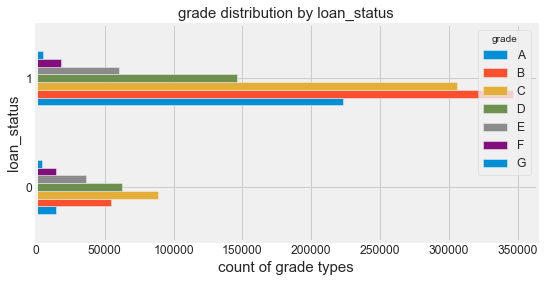

,feature,Description
25,grade,LC assigned loan grade


In [62]:
plot_aggregate_bar_plot('grade','loan_status')

From the plot above, loan grades 'C' and 'D' seem to be the worst performers in terms of defaulting

In [63]:
helpers.data_dictionary(['emp_length'])
pd.crosstab(df['loan_status'], df['emp_length'])

,feature,Description
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
loan_status,,,,,,,,,,,
0,18757,85810,24916,22171,16447,17026,12521,11901,12418,10385,22961
1,72373,367471,100330,88513,66528,69426,51856,49026,49625,41646,88807


The table above does not give us any solid insight regarding borrowers behaviour in relation to the number of years employed. <br>
I would have thought folks with less than 1  year employment would make the majority of defaulted loans, but it does not seem to be the case <br>
as we can see that self reported 10+ years employment lengths have the most defaults in the dataset. 

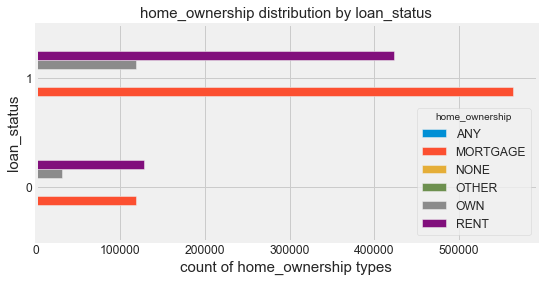

,feature,Description
26,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"


In [64]:
plot_aggregate_bar_plot('home_ownership','loan_status')

Seems like both home owners and renters have more or less the same chance at defaulting on a loan.

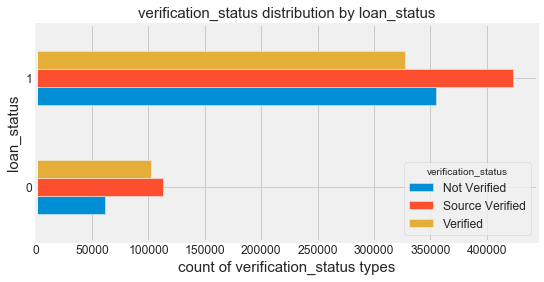

,feature,Description
112,verification_status,"Indicates if income was verified by LC, not verified, or if the income source was verified"


In [65]:
plot_aggregate_bar_plot('verification_status','loan_status')

The plot above reveals that verifiying incomes is not a significant signal for defaulting borrowers as see verified loans making the majority <br>
of loan defaulters. One would expect non-verified loans to be dominating this category. We can also see for non-defaulters that non-verified <br>
incomes were also more prevelant. 

### Skewness
Skewness can be described as a departure from symmetry and is a measure to determine or give us a hint as to how biased <br>
some of the features in our dataset are. The plot below gives us the top 10 skewed features. 

In [66]:
# grab the indexes of numeric features
numeric_features = df.dtypes[df.dtypes!= 'object'].index

# use the skew function to calculate skewness
skew_features = df[numeric_features].skew().sort_values(ascending=False)

# create a dataframe to visualize
skew_df = pd.DataFrame({'skew_features':skew_features})


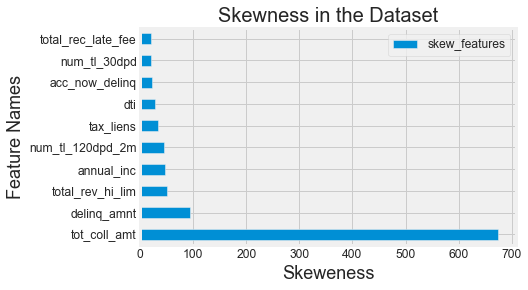

In [67]:
skew_df.head(10).plot(kind='barh',);
plt.xlabel("Skeweness",size=18)
plt.ylabel("Feature Names",size=18)
plt.title("Skewness in the Dataset", size=20)
plt.show();

### **Check for Correlation**

Highly correlated features lead to poor performance when it comes to the modeling phase and coming up with accurate predictions <br>
It is imperative that we determine which features are correlated and tag them for removal during the pre-processing phase. We look at a few <br>
instances below

In [68]:
# We will break the different numeric features and categorical features into seprate bins for easy analysis
dollar_amounts_1= ["loan_amnt","annual_inc","revol_bal","tot_cur_bal","avg_cur_bal","loan_status"]
dollar_amounts_2 = ["tot_cur_bal","avg_cur_bal","loan_status",'total_bal_il','total_rev_hi_lim']

numeric_features_1 = ["emp_length","dti","mths_since_last_delinq","loan_status"]
numeric_features_2 = ["loan_status",'term','inq_last_6mths','total_acc','mo_sin_old_il_acct',]

numeric_features_combined = numeric_features_1 + numeric_features_2
dollar_ammount_features = dollar_amounts_1 + dollar_amounts_2

numeric_corrs = numeric_features_combined + dollar_ammount_features

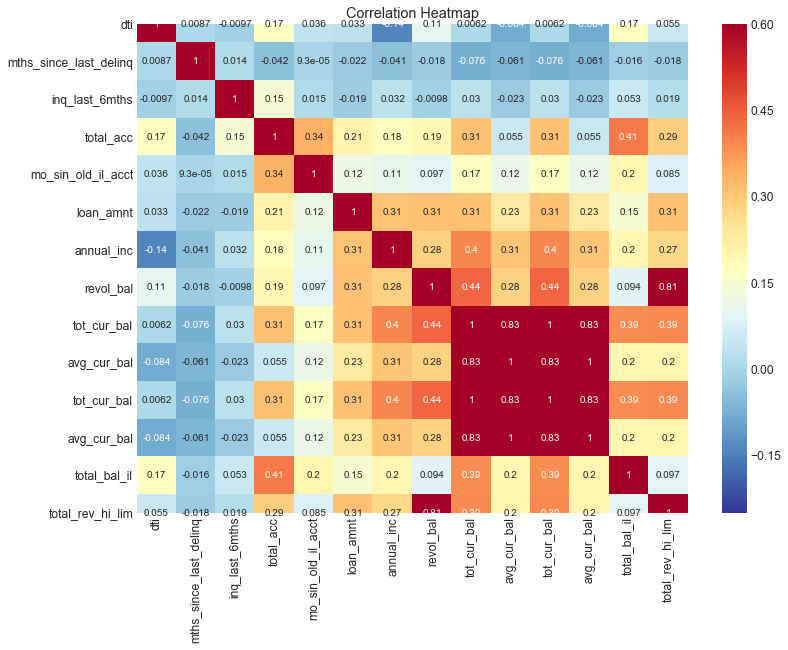

In [69]:
plt.figure(figsize = (11, 9));

# Heatmap of correlations
sns.heatmap(df[numeric_corrs].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Taking a sample of the numeric features, we can see that the dataset does have some highly correlated features specifically:
* total_cur_bal and avg_cur_bal
* total_rev_hi_lim and revol_bal

In [70]:
# We will break the different numeric features and categorical features into seprate bins for easy analysis
dollar_amounts= ["loan_amnt","annual_inc","revol_bal","tot_cur_bal","avg_cur_bal","term","loan_status"]

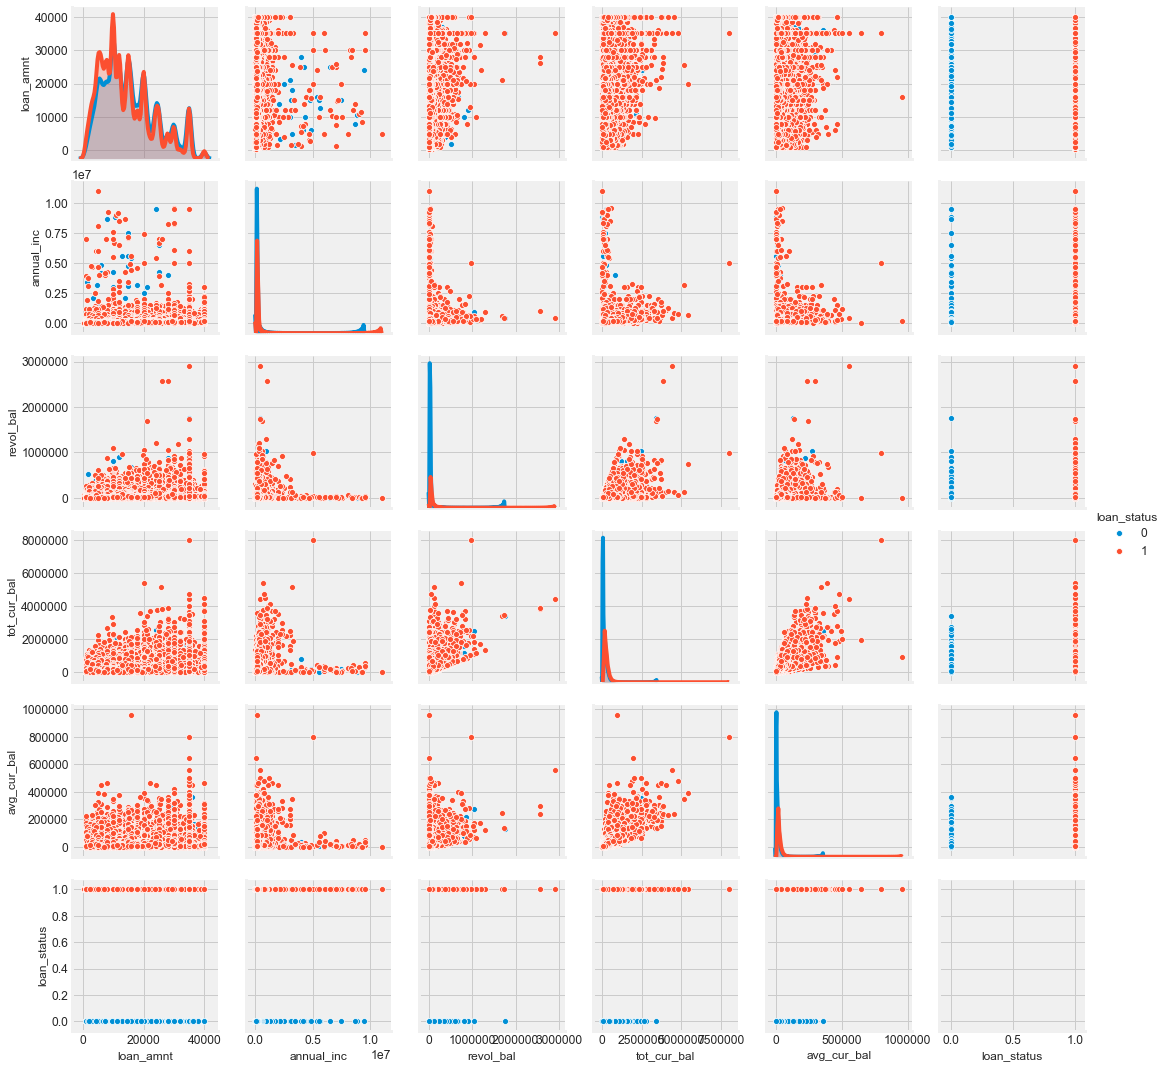

In [71]:
sns.pairplot(df[dollar_amounts],hue="loan_status");

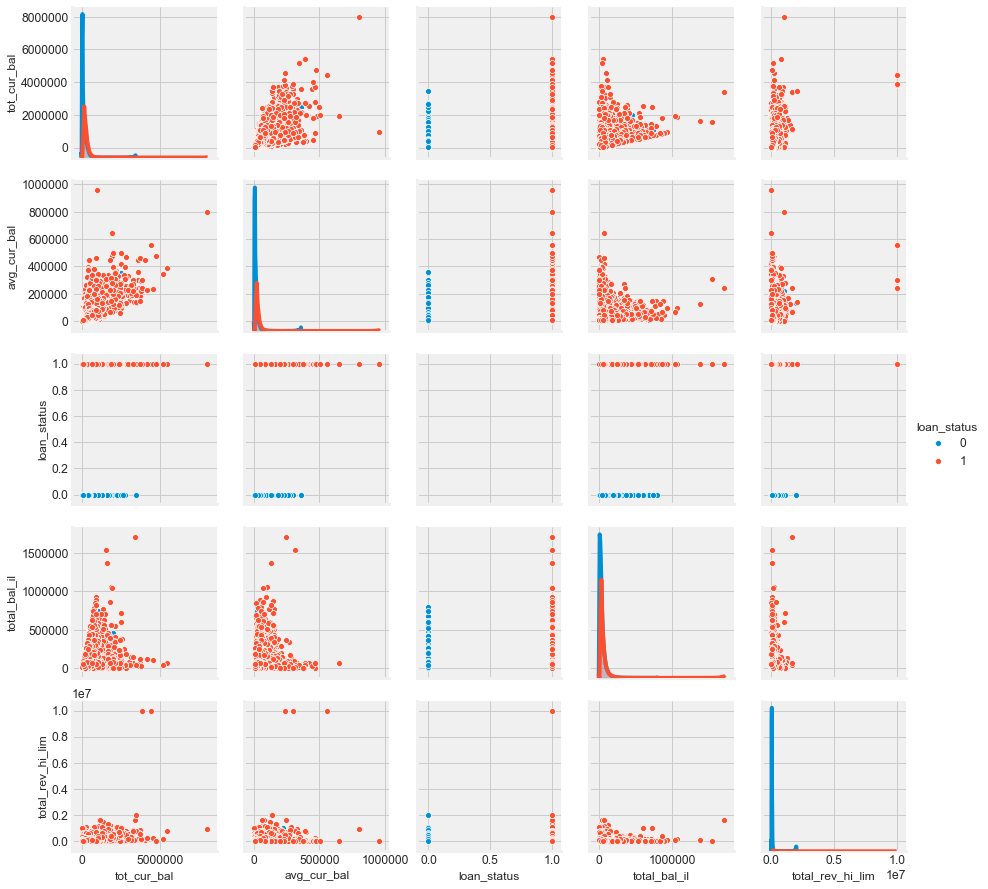

In [72]:
sns.pairplot(df[dollar_amounts_2],hue="loan_status");

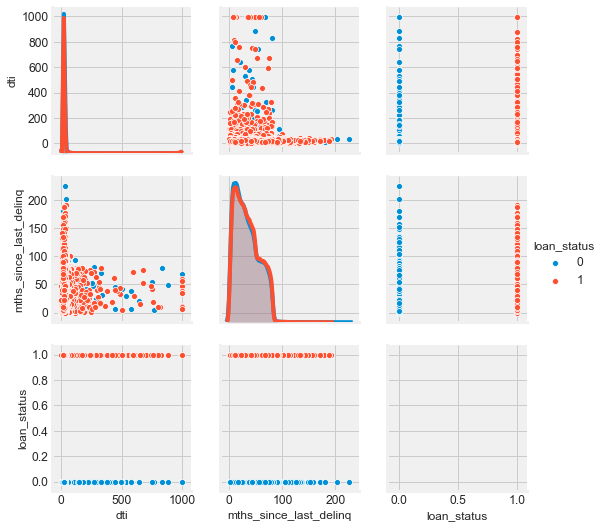

In [73]:
sns.pairplot(df[numeric_features_1],hue="loan_status");

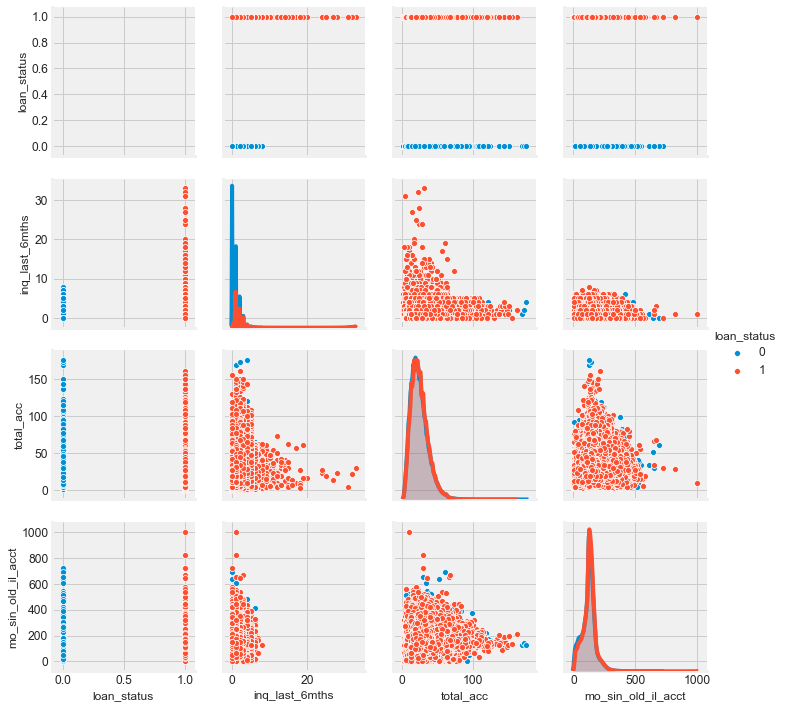

In [74]:
sns.pairplot(df[numeric_features_2],hue="loan_status");

Scatter plots below can show how each of the features interact in terms of correlation, same as the correlation plot. We cannot see overly <br>
significant relationships between the different features above. We can also surmise from the plot a generally non-linear problem.

### Lets prod the data using different intuition 

We know that grade A is the highest grade given and D is the lowest. Based on that lets see how those groups differ based on additional factors.

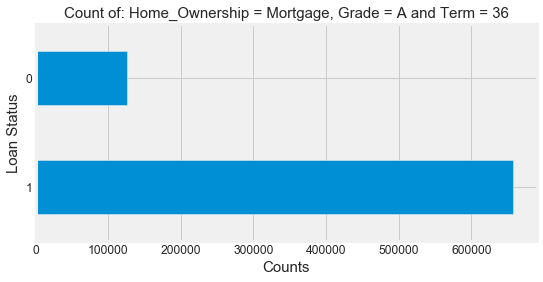

In [75]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'MORTGAGE') | (df['grade'] == 'A')) | (df['term'] == '36 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = Mortgage, Grade = A and Term = 36",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

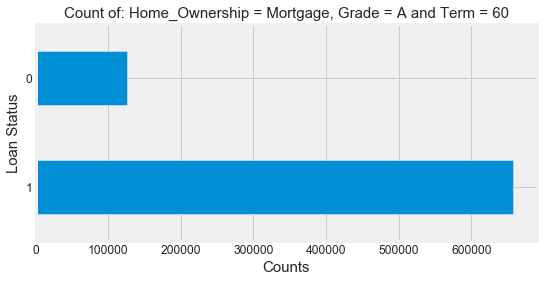

In [76]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'MORTGAGE') | (df['grade'] == 'A')) | (df['term'] == '60 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = Mortgage, Grade = A and Term = 60",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

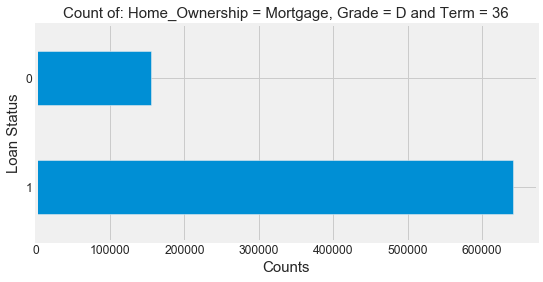

In [77]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'MORTGAGE') | (df['grade'] == 'D')) | (df['term'] == '36 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = Mortgage, Grade = D and Term = 36",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

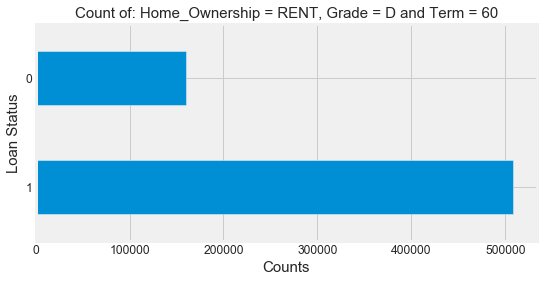

In [78]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'RENT') | (df['grade'] == 'D')) | (df['term'] == '60 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = RENT, Grade = D and Term = 60",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

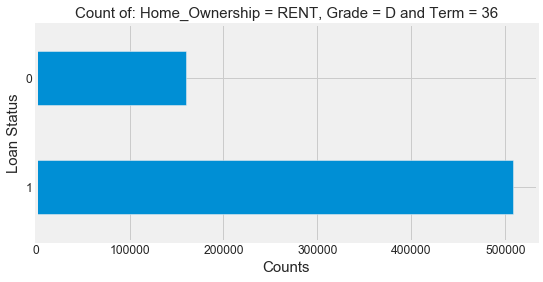

In [79]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'RENT') | (df['grade'] == 'D')) | (df['term'] == '36 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = RENT, Grade = D and Term = 36",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

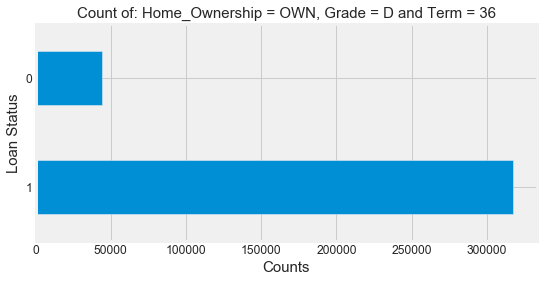

In [80]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'OWN') | (df['grade'] == 'A')) | (df['term'] == '36 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = OWN, Grade = D and Term = 36",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

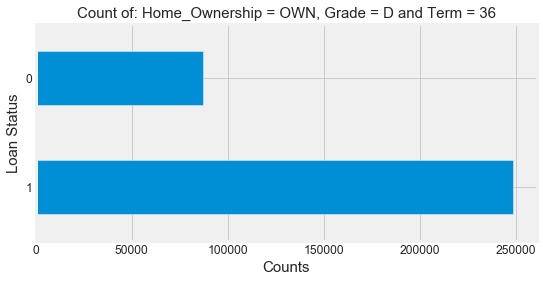

In [81]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'OWN') | (df['grade'] == 'D')) | (df['term'] == '36 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = OWN, Grade = D and Term = 36",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

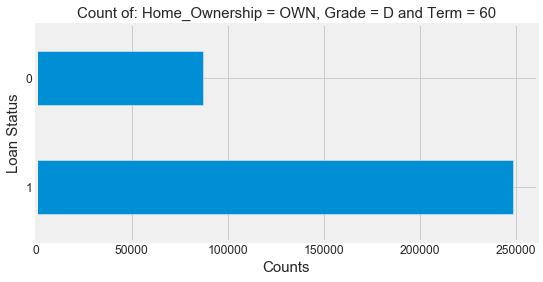

In [82]:
# select term = 36 months and grade = A
df_temp = df[((df['home_ownership'] == 'OWN') | (df['grade'] == 'D')) | (df['term'] == '60 months')]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of: Home_Ownership = OWN, Grade = D and Term = 60",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

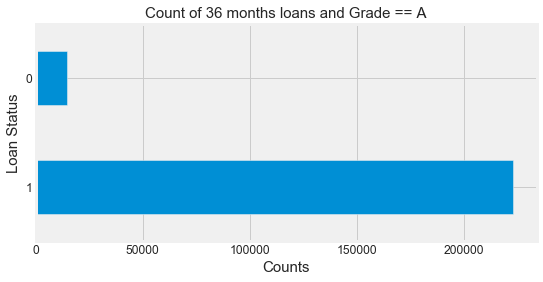

In [83]:
# select term = 36 months and grade = A
df_temp = df[((df['term'] == '36 months') | (df['grade'] == 'A'))]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of 36 months loans and Grade == A",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

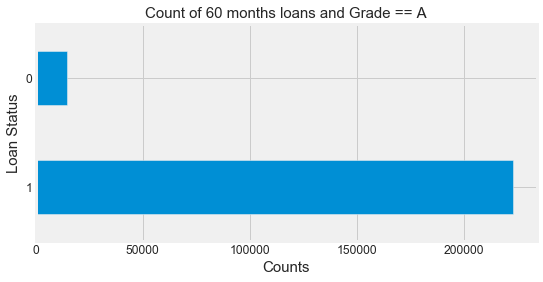

In [84]:
# select term = 36 months and grade = A
df_temp = df[((df['term'] == '60 months') | (df['grade'] == 'A'))]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of 60 months loans and Grade == A",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

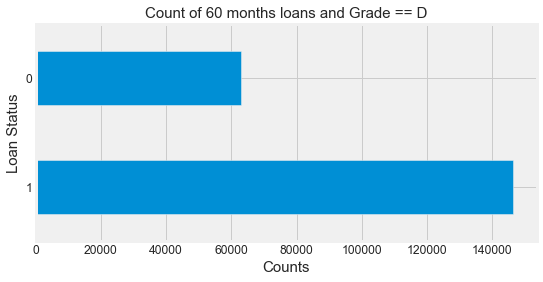

In [85]:
# select term = 36 months and grade = A
df_temp = df[((df['term'] == '60 months') | (df['grade'] == 'D'))]
# plot a bar graph based on the loan status
df_temp.loan_status.value_counts().plot(kind='barh',figsize=(8,4));
plt.title("Count of 60 months loans and Grade == D",size=15);
plt.xlabel('Counts', size=15); plt.ylabel('Loan Status',size=15)
plt.show();

We see a significant difference between loans Graded A through D and their relative performance in terms of loan repayment. <br>
The worst of them seem to be loans with a term of 60 and grade of D. <br>

We can also infer that Grade A loans are generally good performers. I am curious as to how the Lending Club assigns grades. Are they leveraging <br>
another algorithm for this purpose?

## Time-Series Analysis
<a id="timeseries"></a>

Time series analysis is the endeavor of extracting meaningful summary and statistical information from points arranged in chronological order (Nielsen, 2019). <br>
Data suitable for time-series analysis comes in the form of a sequence of quantitative observations about a system or process that have been made at successive points in time (Prakash and Pal, 2017).

Our dataset can be analyzed for trends over time for specific continous features to allow forecasting for future planning. Such features include loan amount, annual_income and interest rates to name a few. <br>
We will look at a few features and analze their trends

We create the function below to easily run fbprophet on individual features. More on fbProphet below <br>
[fbProphet Details](https://facebook.github.io/prophet/)

In [86]:
# ill create this function to easily run fbprophet on individual features
def prophet_timeseries(feature_name):
    
    # field_name = feature_name
    
    timeseries_dataframe = df[['issue_d',feature_name]]
    timeseries_dataframe.dropna(how='all', inplace=True)
    timeseries_dataframe.columns = ['ds', 'y']
    
    prophet = Prophet()
    prophet.fit(timeseries_dataframe)
    
    # revolving balance
    prophet_future = prophet.make_future_dataframe(periods=365)
    prophet_forecast = prophet.predict(prophet_future)

    #fig1 = prophet.plot(prophet_forecast);
    fig2 = prophet.plot_components(prophet_forecast);   

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


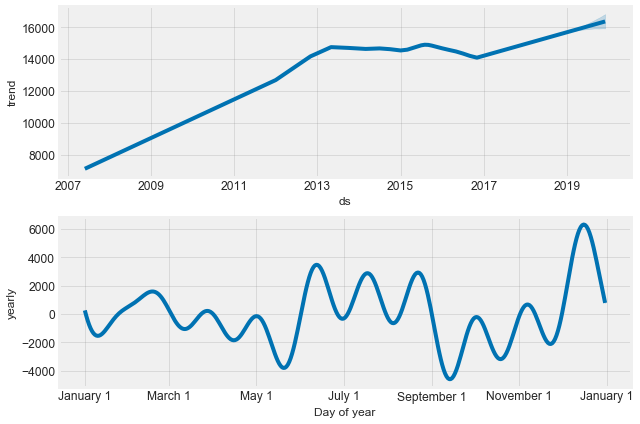

In [87]:
prophet_timeseries('loan_amnt')

Plot above shows that loan amounts have beeen steadily increasing since 2007.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


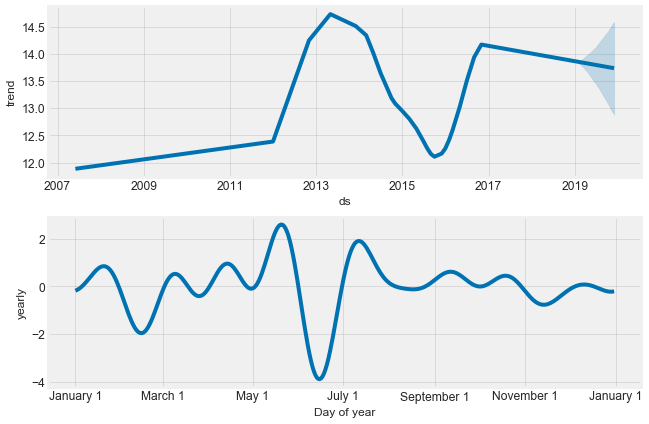

In [88]:
prophet_timeseries('int_rate')

### References
Consumer Financial Protection Bureau (CFPB) (2019) 'What is a debt-to-income ratio? Why is the 43% debt-to-income ratio important?' <br>
Available at:https://www.consumerfinance.gov/ask-cfpb/what-is-a-debt-to-income-ratio-why-is-the-43-debt-to-income-ratio-important-en-1791/ <br>

Nielsen, A (2019) 'Practical Time Series Analysis' Orielly Media Inc. <br>

Prakash and Pal (2017) 'Practical Time Series Analysis' Packt Publishing. <br>
